In [63]:
#Import required libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report, roc_auc_score, roc_curve
from sklearn import metrics, svm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
#Load dataset
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
#Check info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


The dataset consists of 299 rows and 12 columns. The data types are floats and integers. Our data also has no missing values.

In [4]:
#Find catergorical vs numerical features in the dataset
col = list(df.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(df[i].unique()) > 2:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)


Categorical Features : anaemia diabetes high_blood_pressure sex smoking DEATH_EVENT
Numerical Features : age creatinine_phosphokinase ejection_fraction platelets serum_creatinine serum_sodium time


Categorical features are defined if the the attribute has less than 2 unique elements else it is a numerical feature.

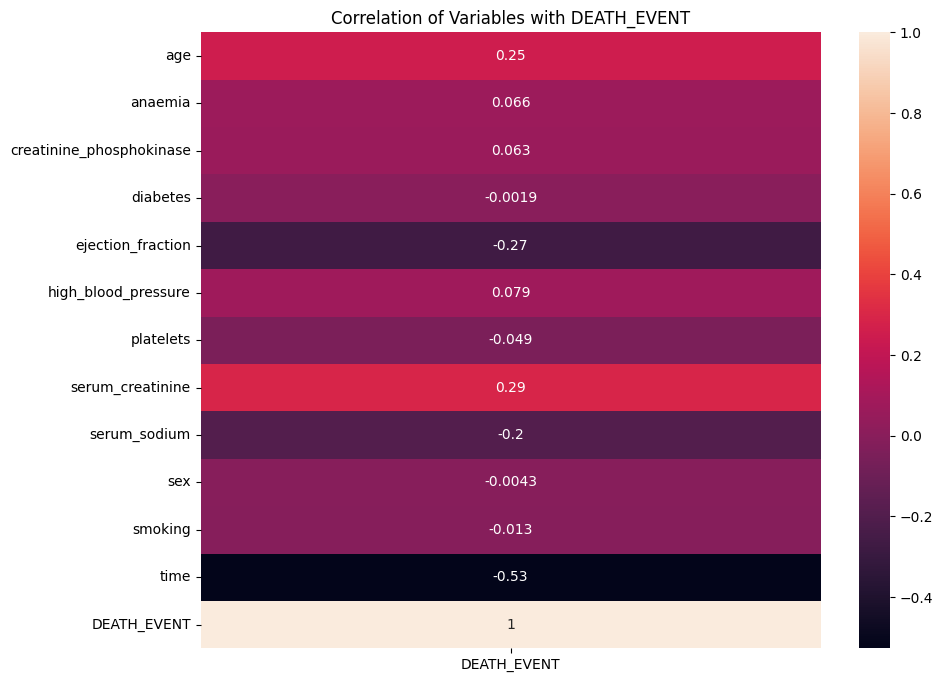

In [5]:
#Create a heatmap to determine the correlation between our independent variables and our target variable.
corrmat = df.corr()
# Select 'DEATH_EVENT' column
corr_death_event = corrmat['DEATH_EVENT']

# Plot the correlations of 'DEATH_EVENT' with other variables
plt.figure(figsize=(10,8))
sns.heatmap(corr_death_event.to_frame(), annot=True)
plt.title('Correlation of Variables with DEATH_EVENT')
plt.show()

C:\Users\T\AppData\Local\Temp\ipykernel_1324\1931240306.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x= df["DEATH_EVENT"], palette=colors)


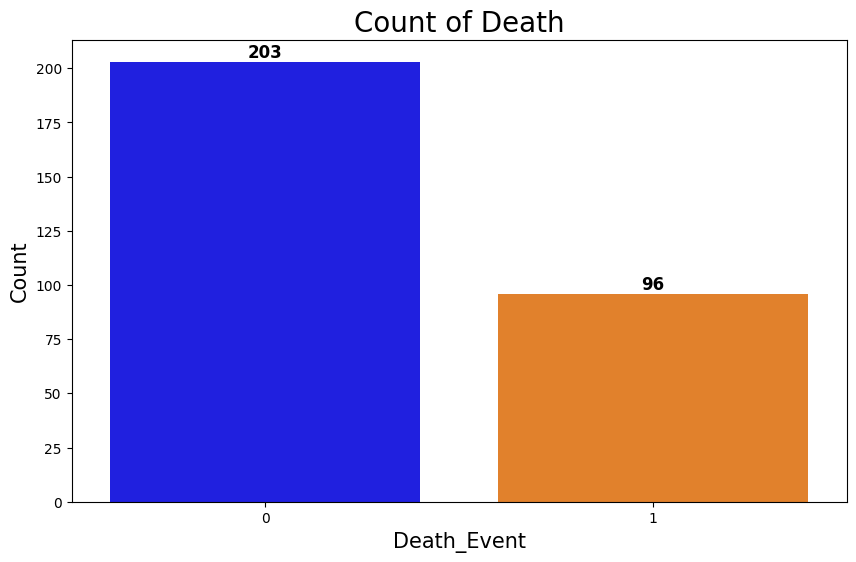

In [6]:
# Check the distribution of death event vs no death event 
colors = ["#0000FF", "#ff7f0e"]

# Create the plot
plt.figure(figsize=(10, 6))  # Increase the size of the figure
ax = sns.countplot(x= df["DEATH_EVENT"], palette=colors)

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', color='black', weight='bold', fontsize=12)

# Add a title and labels for the x and y axes
plt.title('Count of Death', fontsize=20)
plt.xlabel('Death_Event', fontsize=15)
plt.ylabel('Count', fontsize=15)

# Show the plot
plt.show()

The distribution of target labels is 203 to 96, indicating there is an imbalance in the data. This means our data will be more biased towards no death events and any visuals during our EDA will show the same bias.

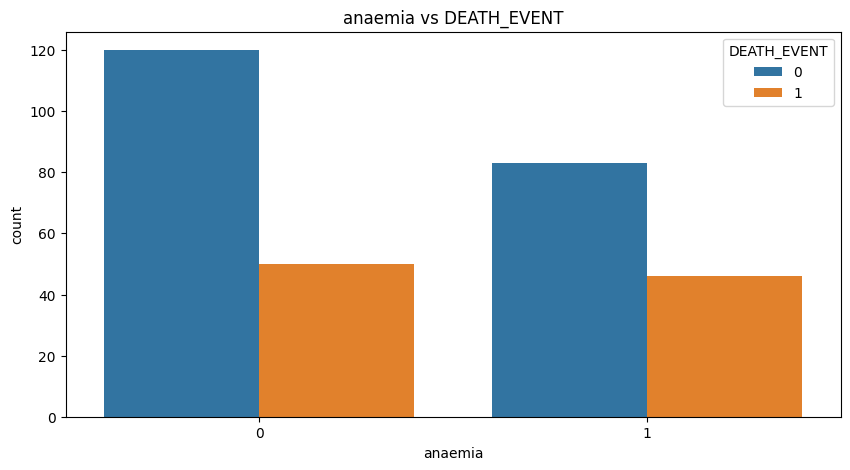

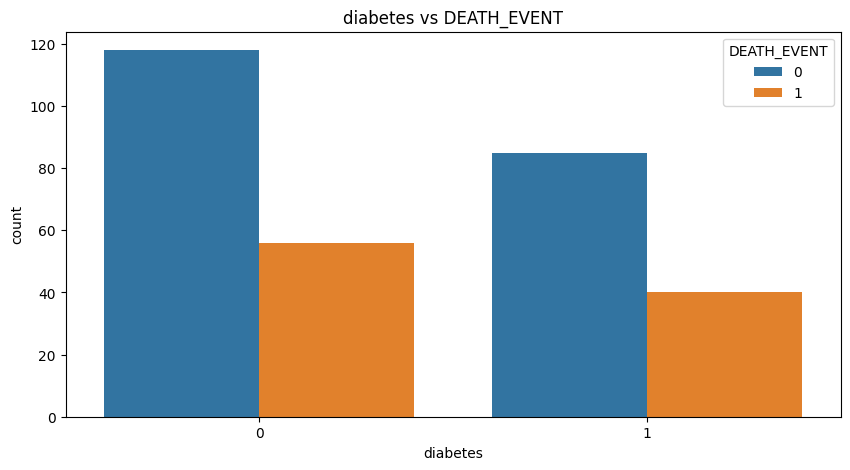

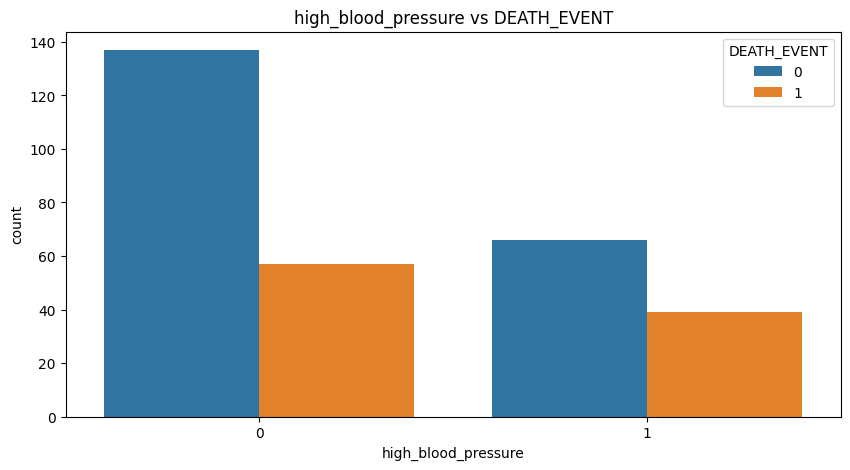

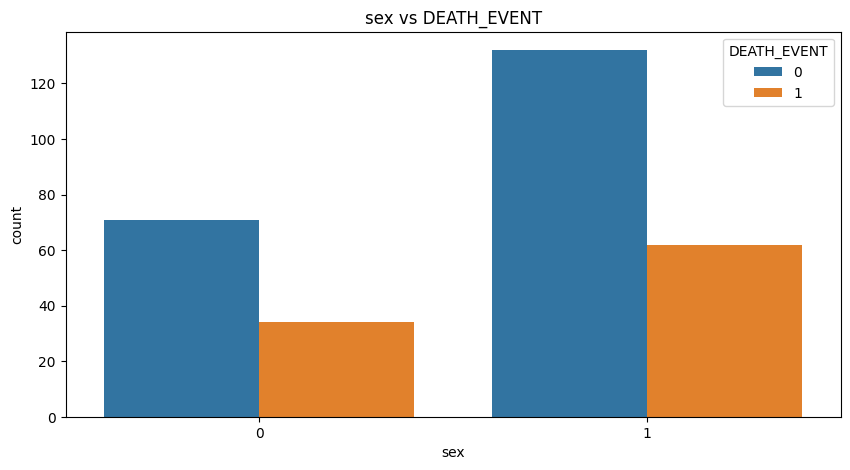

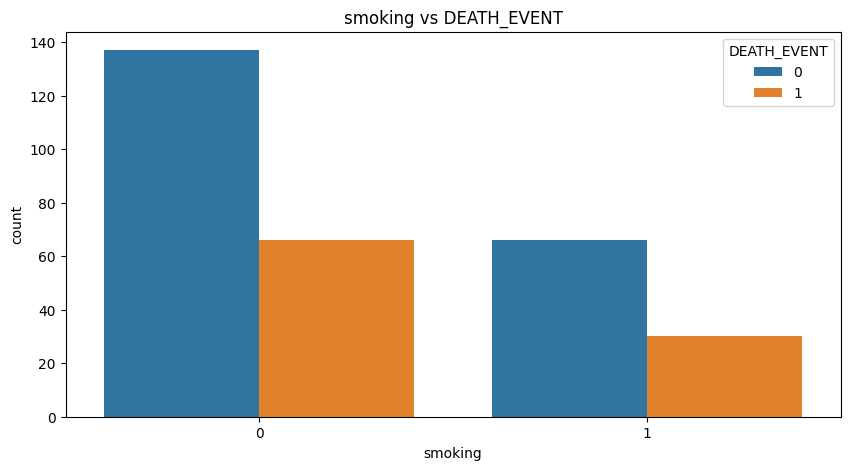

In [7]:
#plotting catergorical features vs death event
categorical_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

for feature in categorical_features:
    plt.figure(figsize=(10,5))
    sns.countplot(x=feature, hue='DEATH_EVENT', data=df)
    plt.title(f'{feature} vs DEATH_EVENT')
    plt.show()

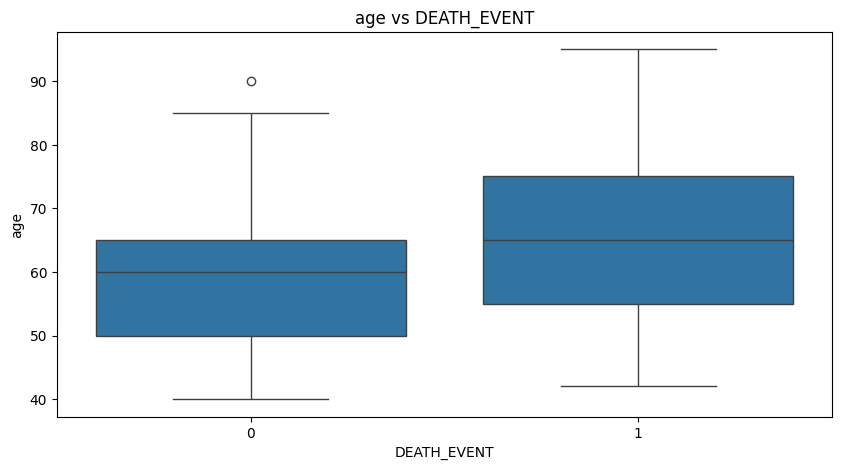

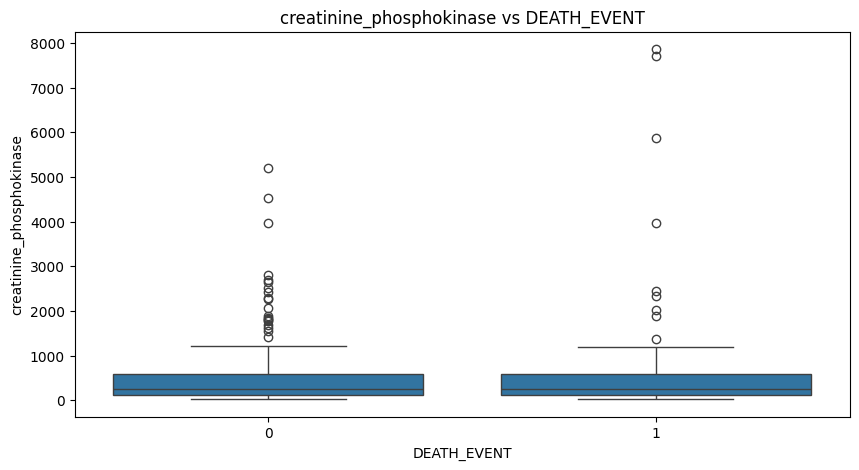

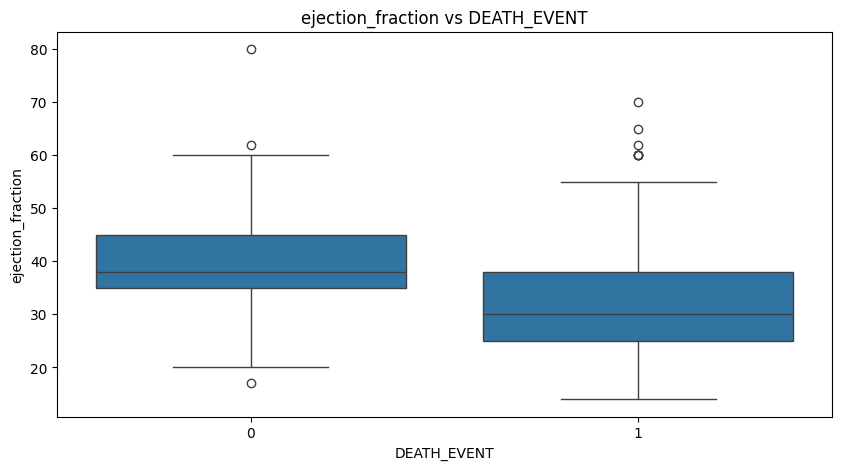

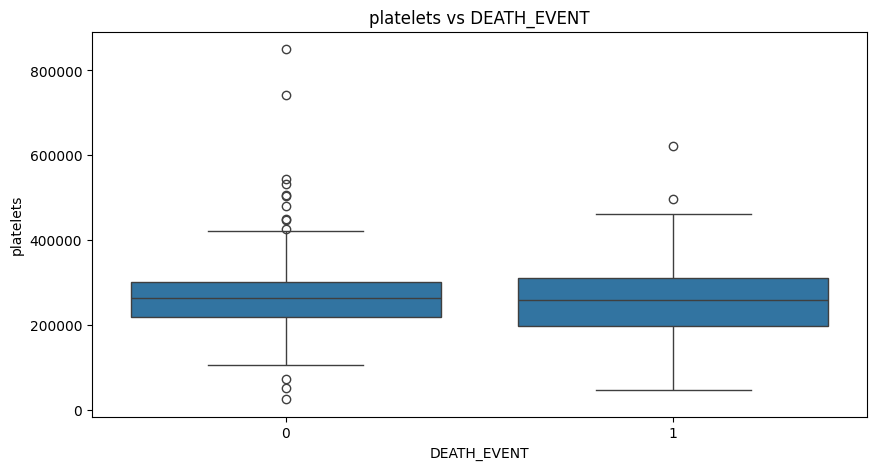

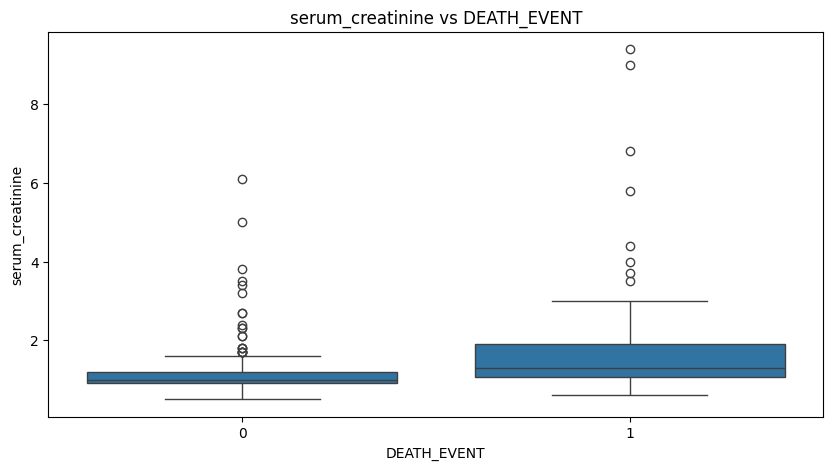

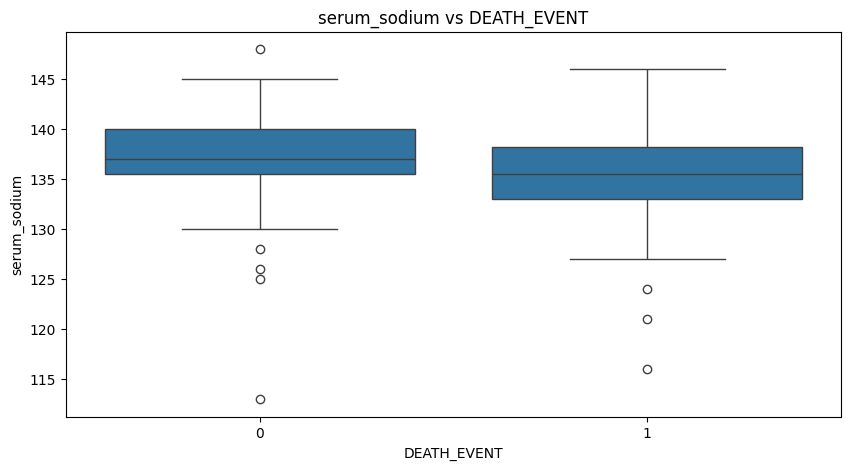

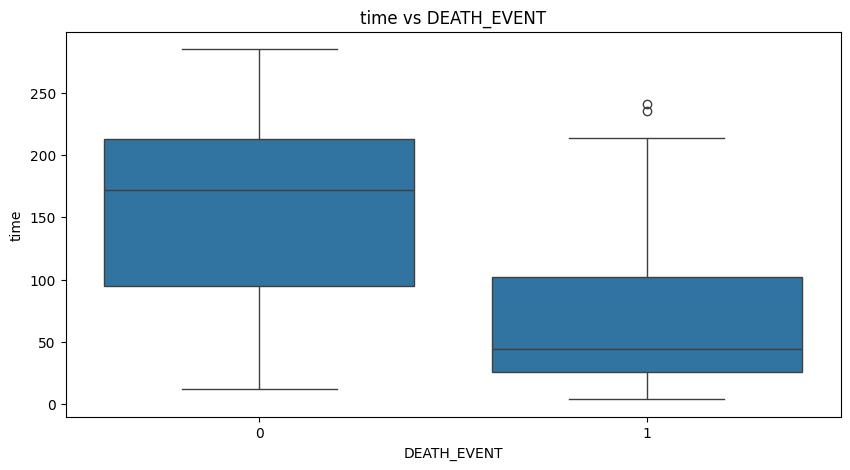

In [8]:
#Plotting numerical features vs death event
numerical_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

for feature in numerical_features:
    plt.figure(figsize=(10,5))
    sns.boxplot(x='DEATH_EVENT', y=feature, data=df)
    plt.title(f'{feature} vs DEATH_EVENT')
    plt.show()

In [9]:
#Convert age and platelets into int type 
df['age'] = df['age'].astype(dtype='int64')
df['platelets'] = df['platelets'].astype(dtype='int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    int64  
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    int64  
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(1), int64(12)
memory usage: 30.5 KB


In [10]:
#Scale data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

# Normalization
df['age'] = mms.fit_transform(df[['age']])
df['creatinine_phosphokinase'] = mms.fit_transform(df[['creatinine_phosphokinase']])
df['ejection_fraction'] = mms.fit_transform(df[['ejection_fraction']])
df['serum_creatinine'] = mms.fit_transform(df[['serum_creatinine']])
df['time'] = mms.fit_transform(df[['time']])
df['platelets'] = mms.fit_transform(df[['platelets']])
df['serum_sodium'] = mms.fit_transform(df[['serum_sodium']])
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,0.636364,0,0.071319,0,0.090909,1,0.290823,0.157303,0.485714,1,0,0.000000,1
1,0.272727,0,1.000000,0,0.363636,0,0.288833,0.067416,0.657143,1,0,0.007117,1
2,0.454545,0,0.015693,0,0.090909,0,0.165960,0.089888,0.457143,1,1,0.010676,1
3,0.181818,1,0.011227,0,0.090909,0,0.224148,0.157303,0.685714,1,0,0.010676,1
4,0.454545,1,0.017479,1,0.090909,0,0.365984,0.247191,0.085714,0,0,0.014235,1


Machine learning model does not understand the units of the values of the features. It treats the input just as a simple number but does not understand the true meaning of that value. Hence, why it becomes necessary to scale the data.

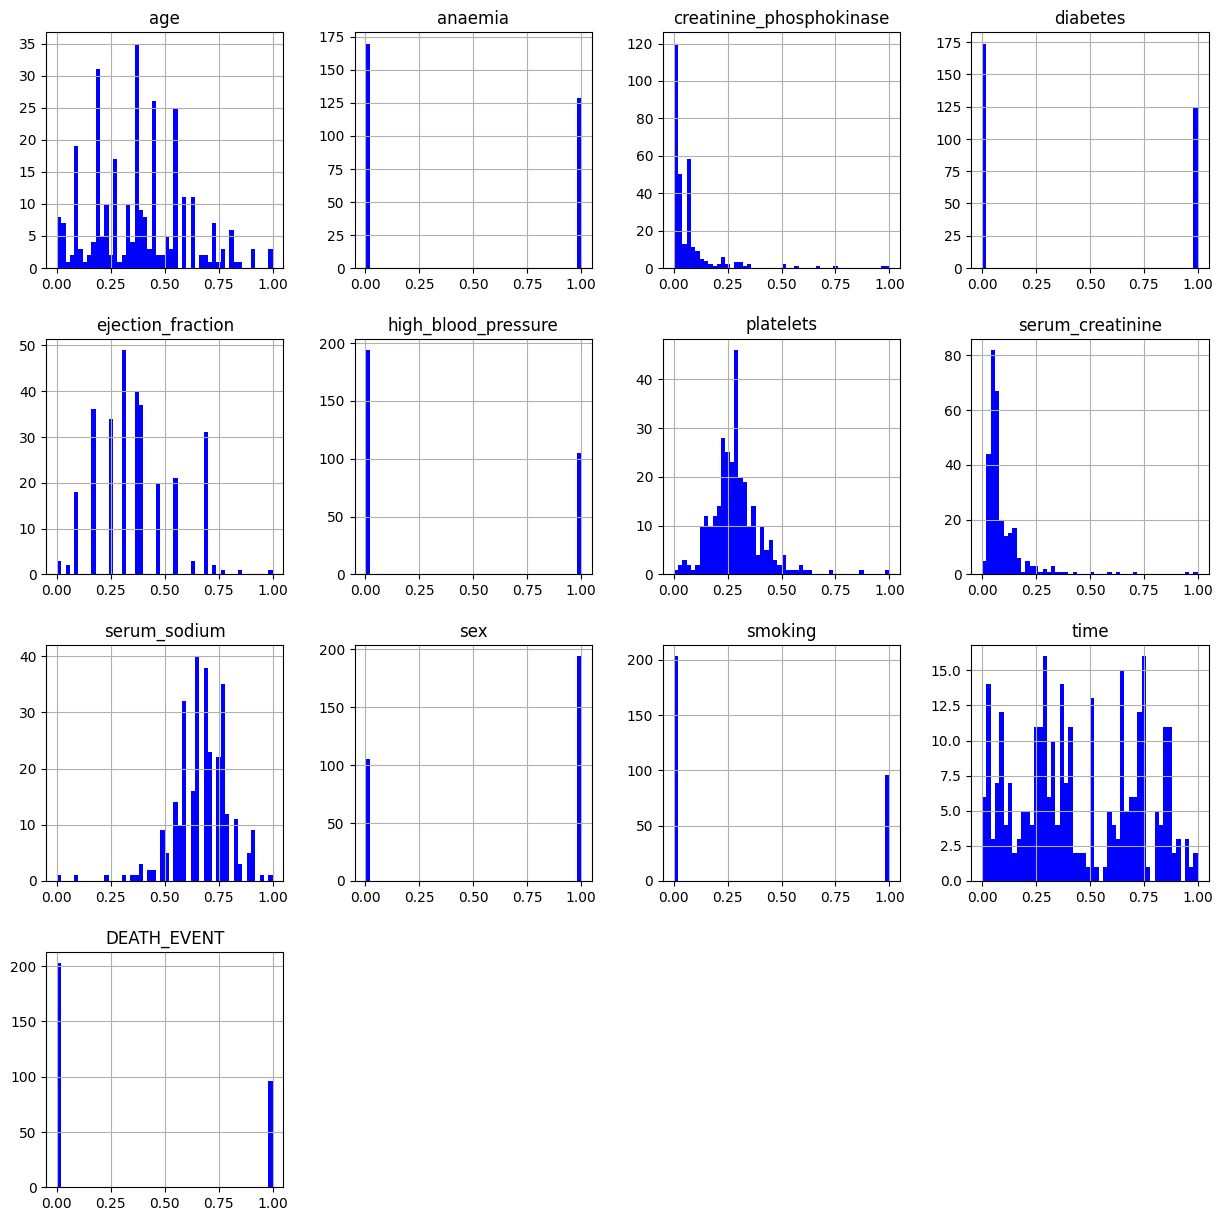

In [11]:
#View the distribution of the data
df.hist(bins=50, figsize=(15,15), color= 'Blue',)
plt.show()

In [12]:
df.shape

(299, 13)

In [13]:
## split the data into independent and dependent variable
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values


In [14]:
## split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 32)


The accuracy of the SVM(rbf) model is 80.00%
RMSE: 0.2
F1 Score: 0.62


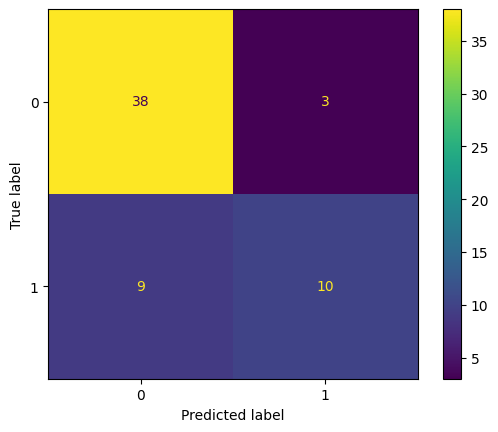

In [15]:
#Define and fit the SVM model
rbf_model = svm.SVC(kernel='rbf')
rbf_model.fit(X_train,y_train)

#Make predictions
predictions_rbf = rbf_model.predict(X_test)

#Check metrics
accuracy = accuracy_score(y_test, predictions_rbf)
print(f'The accuracy of the SVM(rbf) model is {accuracy*100:.2f}%')
print('RMSE:',metrics.mean_squared_error(y_test,predictions_rbf))
f1 = f1_score(y_test, predictions_rbf)
print(f'F1 Score: {f1:.2f}')

#Print confusion matrix
cm = confusion_matrix(y_test, predictions_rbf)
cmd = ConfusionMatrixDisplay(cm, display_labels=rbf_model.classes_)
cmd.plot()

In [48]:
# initialise the neural network
model = Sequential()

# Setup input layer
model.add(Dense(units=30, kernel_initializer = 'he_uniform', activation = 'relu', input_dim = 12))

# Hidden layer 1
model.add(Dense(units=20, kernel_initializer = 'he_uniform', activation = 'relu')) 

# Regularization
model.add(Dropout(0.3))

# Hidden layer 2
model.add(Dense(units=10, kernel_initializer = 'he_uniform', activation = 'relu')) 

# Regularization
model.add(Dropout(0.3))

# Hidden layer 3
model.add(Dense(units=5, kernel_initializer = 'he_uniform', activation = 'relu')) 

# Regularization
model.add(Dropout(0.3))

# Output layer 
model.add(Dense(units=1, kernel_initializer = 'he_uniform', activation = 'sigmoid'))

# Define early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

# Compiling the network
opt = Adam(learning_rate=0.003)  # Decreased learning rate
model.compile(optimizer=opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [49]:
# Train network 
history = model.fit(X_train, y_train, batch_size=40, epochs=100, validation_split=0.3, callbacks=[es])

Epoch 1/100
5/5 [==============================] - 2s 55ms/step - loss: 0.7129 - accuracy: 0.5868 - val_loss: 0.6014 - val_accuracy: 0.7361
Epoch 2/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6529 - accuracy: 0.6108 - val_loss: 0.6104 - val_accuracy: 0.7361
Epoch 3/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6913 - accuracy: 0.6287 - val_loss: 0.6211 - val_accuracy: 0.7361
Epoch 4/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6448 - accuracy: 0.7006 - val_loss: 0.6222 - val_accuracy: 0.7361
Epoch 5/100
5/5 [==============================] - 0s 11ms/step - loss: 0.6763 - accuracy: 0.6467 - val_loss: 0.6217 - val_accuracy: 0.7361
Epoch 6/100
5/5 [==============================] - 0s 13ms/step - loss: 0.6477 - accuracy: 0.6647 - val_loss: 0.6169 - val_accuracy: 0.7500
Epoch 7/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6722 - accuracy: 0.6228 - val_loss: 0.6257 - val_accuracy: 0.7639
Epoch 8/100
5/5 [===

In [50]:
## Make prediction
y_pred_model = model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [51]:
y_pred_model

array([[0.20660147],
       [0.03623102],
       [0.017133  ],
       [0.86555964],
       [0.23566191],
       [0.0559122 ],
       [0.20595923],
       [0.01142945],
       [0.1590746 ],
       [0.21645814],
       [0.05382321],
       [0.23884635],
       [0.28990006],
       [0.91761094],
       [0.2614305 ],
       [0.15486175],
       [0.20625402],
       [0.07213233],
       [0.15546921],
       [0.5956755 ],
       [0.52293473],
       [0.98306006],
       [0.16068052],
       [0.14755444],
       [0.88989854],
       [0.2493923 ],
       [0.07335555],
       [0.4425424 ],
       [0.7991211 ],
       [0.06812694],
       [0.99481446],
       [0.09614202],
       [0.9966501 ],
       [0.1629829 ],
       [0.93815947],
       [0.08577748],
       [0.06700183],
       [0.06569254],
       [0.08491772],
       [0.99668664],
       [0.9404924 ],
       [0.9496564 ],
       [0.06496388],
       [0.11389487],
       [0.6802174 ],
       [0.15803558],
       [0.950546  ],
       [0.998

In [52]:
## Set threshold
y_pred_model = np.where(y_pred_model >0.5, 1, 0)
y_pred_model

array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0]])

In [53]:
#View the shape of actual data vs predictions
print(y_test.shape)
print(y_pred_model.shape)

(60,)
(60, 1)


In [54]:
#Flatten the y_pred_ann
y_pred_model=y_pred_model.flatten()

In [55]:
#Create dataframe for actual results vs test results
pd.DataFrame({'Actual':y_test, 'Predicted':y_pred_model})

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,1,1
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [56]:
##Classification report
print(classification_report(y_test,y_pred_model))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84        41
           1       0.67      0.63      0.65        19

    accuracy                           0.78        60
   macro avg       0.75      0.74      0.75        60
weighted avg       0.78      0.78      0.78        60



In [57]:
##confusion matrix
cmm=confusion_matrix(y_test,y_pred_model)

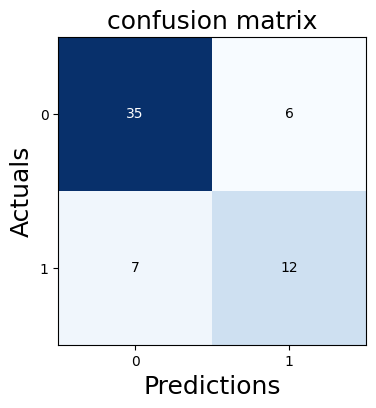

In [58]:
## confusion matrix plot
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=cmm, figsize=(4,4))
plt.xlabel('Predictions', fontsize = 18)
plt.ylabel('Actuals', fontsize = 18)
plt.title('confusion matrix', fontsize = 18)
plt.show()


AUC: 0.742619


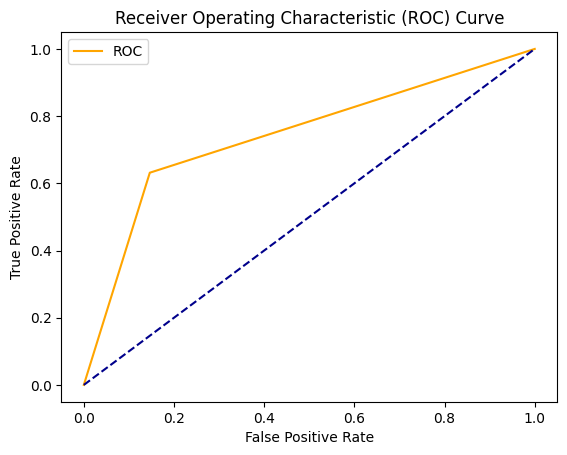

In [59]:
# The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

# Calculate the Area Under the Curve (AUC) for the ROC curve
auc_mod2 = roc_auc_score(y_test, y_pred_model)
# Print the AUC value. The best possible AUC value is 1.0, indicating a perfect classifier, while a purely random classifier will have an AUC of 0.5.
print('AUC: %f' %auc_mod2)
# Compute the points on the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_model)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

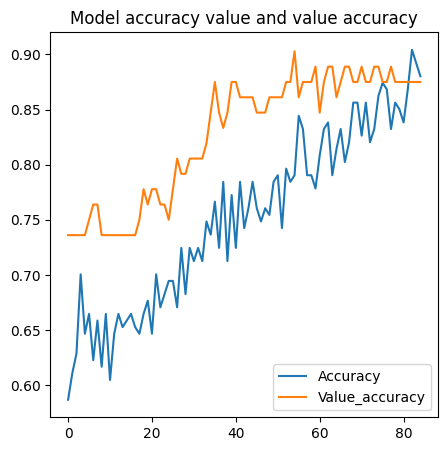

In [60]:
# Plot the training accuracy and validation accuracy of a model over epochs.
plt.figure(figsize=(5,5))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Value_accuracy')
plt.title('Model accuracy value and value accuracy')
plt.legend()
plt.show()

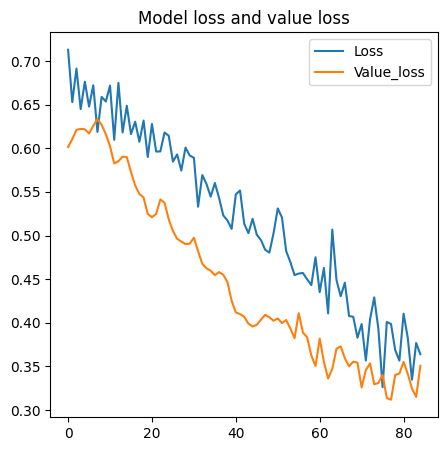

In [61]:
#Plot the training loss and validation loss of a model over epochs.
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label = 'Value_loss')
plt.title('Model loss and value loss')
plt.legend()
plt.show()